#  TWISSTNTERN Plots Playground

## **A Jupyter Notebook For Dasha**

This Notebook contains:
- **2D Residual Analysis**: Compare two datasets using heatmaps and statistical metrics.
- **3D Visualization**: Explore data through an interactive 3D histogram.
- **Model Comparison**: Compare the outputs of different models against a "ground truth" reference.
- **Data Plotting**: Visualize empirical datasets.

---


In [54]:
# IMPORTS AND SETUP
# ============================================================================

# installing torch for the metrics calculation
!pip install torch --index-url https://download.pytorch.org/whl/cpu

# importing torch
import torch

# importing twisstntern
# ============================================================================
try:
    import twisstntern
    import twisstntern.utils
    from twisstntern.utils import (
        dump_data, cartizian, T1_lim, T2_lim, T3_lim, 
        T1, T2, T3, h, return_triangle_coord
    )
    from twisstntern.visualization import get_professional_colormap
    print("✓ TWISSTNTERN library loaded successfully!")
except ImportError as e:
    print(f"✗ Error importing TWISSTNTERN: {e}")
    print("Make sure twisstntern is installed and you're in the correct directory")
    sys.exit(1)

# System / OS / Utilities
import sys
import os
import time
import math
import re
import warnings
from pathlib import Path
import contextlib
import io

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.colors import SymLogNorm, Normalize, ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns

# Scientific Computing / Statistics
from scipy import stats
from scipy.stats import chi2, gaussian_kde


# Optimal transport (for Wasserstein distances)
try:
    import ot
    HAS_OT = True
    print("✓ Optimal transport library loaded")
except ImportError:
    print("⚠️ Installing optimal transport library...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "POT"])
    import ot
    HAS_OT = True
    print("✓ Optimal transport library installed and loaded")




# Import metrics if available
try:
    from dataCompare.metrics import compute_all_metrics, load_data
    print("✓ Custom metrics module loaded")
except ImportError:
    print("⚠️ Custom metrics module not found (metrics.py)")
    compute_metrics = None

# Setup plotting
plt.style.use('default')  # Start with clean style
sns.set_palette("bright")

# Configure matplotlib for better interactivity
#%matplotlib qt5
# matplotlib.use('nbagg')
# %matplotlib nbagg

#%matplotlib widget
%matplotlib inline
print("✓ Interactive matplotlib backend configured")

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


print("Right now- cannot make 3D plots interactive, though they should")


Looking in indexes: https://download.pytorch.org/whl/cpu
✓ TWISSTNTERN library loaded successfully!
✓ Optimal transport library loaded
✓ Custom metrics module loaded
✓ Interactive matplotlib backend configured
Right now- cannot make 3D plots interactive, though they should


In [55]:

# 🎛️ CONFIGURATION PANEL - TWEAKING MADE MORE COMPFORTABLE
# ============================================================================
# 
# File URLs and target names for the residual plot
files_to_download = {
    "NoMigration_topology_weights.csv": "https://raw.githubusercontent.com/HilaLifchitz/twisstntern_article/main/dataCompare/NoMigration_topology_weights.csv",
    "migration_topology_weights.csv": "https://raw.githubusercontent.com/HilaLifchitz/twisstntern_article/main/dataCompare/migration_topology_weights.csv"
}

# Download only if not present
for filename, url in files_to_download.items():
    if not os.path.exists(filename):
        print(f"⬇️ Downloading {filename}...")
        !wget {url}
    else:
        print(f"✅ {filename} already exists, skipping download.")

# Define file paths for later use
DATA_FILE_1 = "migration_topology_weights.csv"      # Reference/Data
DATA_FILE_2 = "NoMigration_topology_weights.csv"    # Model/Comparison

#  ANALYSIS PARAMETERS
GRANULARITY = 0.1           # Grid resolution (smaller = more detailed, larger = faster)
SAMPLE_SIZE = None          # None = use all data, or specify number (e.g., 10000)
SKIP_WASSERSTEIN = True     # True = faster, False = more comprehensive metrics

#  2D VISUALIZATION COLORS
# Choose from: "viridis", "plasma", "inferno", "magma", "cividis", "rocket", "mako", "flare"
DATA_MODEL_COLORMAP = "viridis"     # For data and model count plots
L2_COLORMAP = "magma"               # For L2 distance plots 
L2_COLORMAP_COMPARE = "magma_r"     # FOr L2 in the comparison plot          
RESIDUALS_COLORMAP = "RdBu_r"       # For residual plots (diverging colormap)

# 🔲 EMPTY TRIANGLE APPEARANCE
# Control whether empty triangles show hatching (True) or are plain white (False)
HATCH_DATA = True           # Data/model plots
HATCH_RESIDUALS = False     # Residual plots  
HATCH_L2 = False            # L2 distance plots

# Available hatch patterns: 
# '///' (diagonal)           - original setting  
# '|||' (vertical)           
# '---' (horizontal)
# '+++' (crosses)
# 'xxx' (diagonal crosses)
# '...' (dots)
HATCH_PATTERN = '+++'        # Choose your hatch pattern

# 📊 HISTOGRAM STYLING
HISTOGRAM_COLOR = "#A2C5F2"  # Blue for residuals histogram
KDE_COLOR = "#22223b"        # Dark blue for KDE overlay

# 🎮 3D VISUALIZATION PARAMETERS

COLORMAP_3D = "viridis_r"    # 3D plot colormap
ALPHA_3D = 0.01              # 3D grid granularity 
FIGURE_SIZE_3D = (14, 10)    # 3D figure size

# 💾 OUTPUT SETTINGS
OUTPUT_DIR = "residual_results"  # Where to save results
OUTPUT_PREFIX = "analysis"                # Prefix for output files
SAVE_HIGH_DPI = 300                      # DPI for saved figures

print(" Configuration loaded!")
print(f" Data files: {DATA_FILE_1} vs {DATA_FILE_2}")
print(f" Granularity: {GRANULARITY}")
print(f" 3D settings: {COLORMAP_3D} with α={ALPHA_3D}")


✅ NoMigration_topology_weights.csv already exists, skipping download.
✅ migration_topology_weights.csv already exists, skipping download.
 Configuration loaded!
 Data files: migration_topology_weights.csv vs NoMigration_topology_weights.csv
 Granularity: 0.1
 3D settings: viridis_r with α=0.01


# 🔧 Function Definitions

The following cells contain all the core functions needed for the analysis. You normally don't need to modify these unless you want to customize the underlying algorithms.


In [56]:
# HELPERS- DATA LOADING FUNCTIONS
# ============================================================================

def load_topology_data_twiss(filepath, sample_size=None):
    """
    Load and process topology weights CSV file using twisstntern.utils.dump_data.
    
    Args:
        filepath (str): Path to the CSV file
        sample_size (int, optional): Sample this many points if specified
        
    Returns:
        pd.DataFrame: Processed data with T1, T2, T3 columns
    """
    print(f"📂 Loading data from: {filepath}")
    
    try:
        # Use twisstntern's dump_data function
        data_array = dump_data(str(filepath))
        
        # Convert to DataFrame
        data = pd.DataFrame(data_array, columns=['T1', 'T2', 'T3'])
        
        # Sample if requested
        if sample_size and len(data) > sample_size:
            data = data.sample(n=sample_size, random_state=42)
            print(f"📋 Sampled {sample_size} points from {len(data_array)} total points")
        
        print(f"✅ Loaded {len(data)} data points")
        return data
        
    except Exception as e:
        print(f"⚠️ Error with twisstntern.utils.dump_data: {e}")
        print("🔄 Falling back to manual CSV loading...")
        
        # Fallback to manual loading
        data = pd.read_csv(filepath)
        
        # Skip the topology definitions row if present
        if len(data) > 1:
            first_row = data.iloc[0]
            if any(isinstance(val, str) and '(' in str(val) for val in first_row):
                data = data.iloc[1:]
        
        # Ensure we have T1, T2, T3 columns
        if 'T1' in data.columns and 'T2' in data.columns and 'T3' in data.columns:
            data = data[['T1', 'T2', 'T3']]
        else:
            data = data.iloc[:, :3]
            data.columns = ['T1', 'T2', 'T3']
        
        # Convert to numeric and handle any issues
        for col in ['T1', 'T2', 'T3']:
            data[col] = pd.to_numeric(data[col], errors='coerce')
        
        # Remove any rows with NaN values
        data = data.dropna()
        
        # Normalize each row to sum to 1
        row_sums = data.sum(axis=1)
        data = data.div(row_sums, axis=0)
        
        # Remove points where T2 == T3 (on y-axis)
        data = data[data['T2'] != data['T3']]
        
        # Sample if requested
        if sample_size and len(data) > sample_size:
            data = data.sample(n=sample_size, random_state=42)
            print(f"📋 Sampled {sample_size} points from total points")
        
        print(f"✅ Loaded {len(data)} data points after processing")
        return data


def generate_sample_data(n_points=1000):
    """Generate sample ternary data for demonstration."""
    print(f"🎲 Generating {n_points} sample data points...")
    
    np.random.seed(42)  # For reproducible results
    data_points = []
    
    # Cluster 1: Near the center
    n1 = n_points // 3
    for _ in range(n1):
        t1 = np.random.normal(0.33, 0.1)
        t2 = np.random.normal(0.33, 0.1)
        t3 = 1 - t1 - t2
        if t1 > 0 and t2 > 0 and t3 > 0:
            data_points.append([t1, t2, t3])
    
    # Cluster 2: Near T1 corner
    n2 = n_points // 3
    for _ in range(n2):
        t1 = np.random.beta(2, 1) * 0.8 + 0.1
        t2 = np.random.beta(1, 2) * 0.3
        t3 = 1 - t1 - t2
        if t1 > 0 and t2 > 0 and t3 > 0:
            data_points.append([t1, t2, t3])
    
    # Cluster 3: Near T2 corner
    n3 = n_points - len(data_points)
    for _ in range(n3):
        t1 = np.random.beta(1, 2) * 0.3
        t2 = np.random.beta(2, 1) * 0.8 + 0.1
        t3 = 1 - t1 - t2
        if t1 > 0 and t2 > 0 and t3 > 0:
            data_points.append([t1, t2, t3])
    
    # Convert to DataFrame
    df = pd.DataFrame(data_points, columns=['T1', 'T2', 'T3'])
    
    # Normalize to ensure T1 + T2 + T3 = 1
    row_sums = df.sum(axis=1)
    df = df.div(row_sums, axis=0)
    
    print(f"✅ Generated {len(df)} valid data points")
    return df

print("📊 Data loading functions defined!")


📊 Data loading functions defined!


In [57]:
# HELPERS- GRID ANALYSIS FUNCTIONS
# ============================================================================

def create_triangular_grid_twiss(alpha):
    """Create triangular grid using twisstntern coordinate system."""
    triangles = []
    steps = int(1 / alpha)
    
    for k in range(steps):
        a1 = round(k * alpha, 10)
        b1 = round((k + 1) * alpha, 10)
        
        # T2 goes from 0 to (1 - (k+1)*alpha) in steps of alpha
        T2_upper_limit = round(1 - k * alpha, 10)
        T2_steps = round(T2_upper_limit / alpha)
        
        # First triangle (T3 from [1 - (k+1)*α, 1 - k*α])
        a3_1 = round(1 - (k + 1) * alpha, 10)
        b3_1 = round(1 - k * alpha, 10)
        
        for T2_step in range(T2_steps):
            a2 = round(T2_step * alpha, 10)
            b2 = round((T2_step + 1) * alpha, 10)
            
            if a3_1 >= 0:
                triangles.append({
                    'T1': (a1, b1),
                    'T2': (a2, b2),
                    'T3': (a3_1, b3_1)
                })
            
            # Second triangle - T3 is -alpha from the last coords
            a3_2 = round(a3_1 - alpha, 10)
            b3_2 = round(b3_1 - alpha, 10)
            
            if a3_2 >= 0:
                triangles.append({
                    'T1': (a1, b1),
                    'T2': (a2, b2),
                    'T3': (a3_2, b3_2)
                })
            
            # Update the T3 coordinates for the next T2 step
            a3_1 = a3_2
            b3_1 = b3_2
    
    return triangles


def n_twisstcompare(a1, b1, a2, b2, a3, b3, data):
    """Count points in triangle bin - handles boundary conditions carefully."""
    # Avoid double-counting of data by using < vs <= appropriately
    if a1 == 0:
        condition_a1 = a1 <= data.T1
    else:
        condition_a1 = a1 < data.T1
    
    if a2 == 0:
        condition_a2 = a2 <= data.T2
    else:
        condition_a2 = a2 < data.T2
        
    if a3 == 0:
        condition_a3 = a3 <= data.T3
    else:
        condition_a3 = a3 < data.T3
        
    n = len(data[(condition_a1 & (data.T1 <= b1)) &
                 (condition_a2 & (data.T2 <= b2)) &
                 (condition_a3 & (data.T3 <= b3))])
    return n


def perform_enhanced_grid_analysis(data1, data2, alpha):
    """Perform comprehensive grid-based analysis comparing two datasets."""
    print(f"🔬 Performing grid analysis with α = {alpha}")
    
    triangles = create_triangular_grid_twiss(alpha)
    print(f"📐 Created {len(triangles)} triangular bins")
    
    # Count points in each triangle
    results_df = []
    for triangle in triangles:
        count_data = n_twisstcompare(
            triangle['T1'][0], triangle['T1'][1],
            triangle['T2'][0], triangle['T2'][1],
            triangle['T3'][0], triangle['T3'][1],
            data1
        )
        count_model = n_twisstcompare(
            triangle['T1'][0], triangle['T1'][1],
            triangle['T2'][0], triangle['T2'][1],
            triangle['T3'][0], triangle['T3'][1],
            data2
        )
        
        # Calculate proportions and residuals
        prop_data = count_data / len(data1)
        prop_model = count_model / len(data2)
        prop_residual = prop_data - prop_model
        residual_squared = prop_residual ** 2
        count_residual = count_data - count_model
        
        results_df.append({
            'T1_bounds': triangle['T1'],
            'T2_bounds': triangle['T2'],
            'T3_bounds': triangle['T3'],
            'count_data': count_data,
            'count_model': count_model,
            'prop_data': prop_data,
            'prop_model': prop_model,
            'prop_residual': prop_residual,
            'residual_squared': residual_squared,
            'count_residual': count_residual
        })
    
    results_df = pd.DataFrame(results_df)
    meaningful_triangles = (results_df['count_data'] > 0) | (results_df['count_model'] > 0)
    filtered_results = results_df[meaningful_triangles]
    
    # Calculate comprehensive statistics
    prop1 = results_df['prop_data']
    prop2 = results_df['prop_model']
    l2 = np.linalg.norm(prop1 - prop2) * (1/len(triangles))  # Normalized L2 distance
    
    # Chi-square test
    counts1 = results_df['count_data']
    counts2 = results_df['count_model']
    with np.errstate(divide='ignore', invalid='ignore'):
        chi2_stat = np.nansum((counts1 - counts2) ** 2 / (counts1 + 1e-8))
    dof = (prop1 != 0).sum() - 1
    p_value = 1 - chi2.cdf(chi2_stat, dof)
    
    # Summary statistics
    if len(filtered_results) > 0:
        mean_residual = filtered_results['prop_residual'].mean()
        std_residual = filtered_results['prop_residual'].std()
        max_residual = filtered_results['prop_residual'].abs().max()
        mean_squared_residual = filtered_results['residual_squared'].mean()
    else:
        mean_residual = std_residual = max_residual = mean_squared_residual = 0.0
    
    statistics = {
        'L2_distance': l2,
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'total_data_points': len(data1),
        'total_model_points': len(data2),
        'num_triangles': len(results_df),
        'num_meaningful_triangles': len(filtered_results),
        'num_empty_triangles': len(results_df) - len(filtered_results),
        'degrees_freedom': len(filtered_results) - 1,
        'mean_residual': mean_residual,
        'std_residual': std_residual,
        'max_residual': max_residual,
        'mean_squared_residual': mean_squared_residual
    }
    
    # Print results
    print("\n" + "="*70)
    print("📊 COMPREHENSIVE GRID-BASED METRICS")
    print("="*70)
    print(f"L² Distance:              {statistics['L2_distance']:.6f}")
    print(f"χ² Statistic:             {statistics['chi2_statistic']:.6f}")
    print(f"χ² p-value:               {statistics['p_value']:.6e}")
    print(f"Mean proportional residual: {statistics['mean_residual']:.6f}")
    print(f"Std proportional residual:  {statistics['std_residual']:.6f}")
    print(f"Max |proportional residual|: {statistics['max_residual']:.6f}")
    print(f"Mean squared residual:    {statistics['mean_squared_residual']:.6f}")
    print(f"Data Points:              {statistics['total_data_points']}")
    print(f"Model Points:             {statistics['total_model_points']}")
    print(f"Grid Triangles (Total):   {statistics['num_triangles']}")
    print(f"Meaningful Triangles:     {statistics['num_meaningful_triangles']}")
    print(f"Empty Triangles:          {statistics['num_empty_triangles']}")
    print(f"Degrees of Freedom:       {statistics['degrees_freedom']}")
    print("="*70)
    
    return results_df, statistics

print("🔬 Grid analysis functions defined!")


🔬 Grid analysis functions defined!


In [58]:
# 🎯 Resudual Plot
# ============================================================================

def create_enhanced_comparison_plot(data1, data2, results_df, statistics, alpha, output_path=None):
    """Create comprehensive 2D residual analysis plot."""
    print(" Creating enhanced comparison plot...")
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1.1], hspace=0.25, wspace=0.25)
    
    # Create subplots
    ax1 = fig.add_subplot(gs[0, 0])  # Data
    ax2 = fig.add_subplot(gs[0, 1])  # Model
    ax3 = fig.add_subplot(gs[0, 2])  # Residuals
    ax4 = fig.add_subplot(gs[1, 0])  # L2 Distance
    ax5 = fig.add_subplot(gs[1, 1:]) # Histogram
    
    # Determine count range for consistent scaling
    max_count = max(results_df['count_data'].max(), results_df['count_model'].max())
    min_count = 1 if max_count > 1 else 0
    cmap_seq = plt.get_cmap(DATA_MODEL_COLORMAP)
    
    # Data plot
    plot_ternary_with_colorbar(ax1, results_df, alpha, 'count_data', 'Data', 
                              min_count, max_count, cmap_seq, "Count")
    
    # Model plot
    plot_ternary_with_colorbar(ax2, results_df, alpha, 'count_model', 'Model', 
                              min_count, max_count, cmap_seq, "Count")
    
    # Residuals plot
    plot_heatmap_data_twiss(ax3, results_df, alpha, 'count_residual', 'Residuals')
    vmax_resid = results_df['count_residual'].abs().max()
    norm_resid = Normalize(vmin=-vmax_resid, vmax=vmax_resid)
    cmap_resid = sns.color_palette(RESIDUALS_COLORMAP, as_cmap=True)
    cax3 = inset_axes(ax3, width="3%", height="60%", loc='right', borderpad=2)
    cb3 = plt.colorbar(cm.ScalarMappable(norm=norm_resid, cmap=cmap_resid), cax=cax3)
    cb3.ax.set_title("Count", fontsize=12, fontweight='normal', pad=10)
    
    # L2 plot
    cmap_l2 = plt.get_cmap(L2_COLORMAP)
    l2_per_triangle = np.sqrt(results_df['residual_squared'].values)
    vmax_l2 = np.max(l2_per_triangle) if len(l2_per_triangle) > 0 else 1
    vmin_l2 = 1 if vmax_l2 > 1 else 0
    plot_ternary_with_colorbar(ax4, results_df, alpha, 'l2', 'L² Distance', 
                              vmin_l2, vmax_l2, cmap_l2, "L² Distance")
    
    # Residuals histogram
    meaningful_triangles = (results_df['count_data'] > 0) | (results_df['count_model'] > 0)
    residuals = results_df.loc[meaningful_triangles, 'count_residual'].values
    
    # Histogram in configured color
    ax5.hist(residuals, bins=30, color=HISTOGRAM_COLOR, alpha=0.7, edgecolor='white', density=True)
    
    # Overlay KDE
    if len(residuals) > 1:
        x_grid = np.linspace(residuals.min(), residuals.max(), 200)
        kde = gaussian_kde(residuals)
        ax5.plot(x_grid, kde(x_grid), color=KDE_COLOR, linewidth=2, label="KDE fit")
    
    ax5.set_title('Residuals Distribution (Count)', fontsize=13, fontweight='bold')
    ax5.set_xlabel('Count Residual (Data - Model)', fontsize=12)
    ax5.set_ylabel('Density', fontsize=12)
    
    # Statistics text
    stats_text = (
        f"L²: {statistics['L2_distance']:.4f}\n"
        f"Chi²: {statistics['chi2_statistic']:.1f}\n"
        f"p-value: {statistics['p_value']:.2e}\n"
        f"Mean Residual: {statistics['mean_residual']:.4f}\n"
        f"Std Residual: {statistics['std_residual']:.4f}\n"
        f"Max |Residual|: {statistics['max_residual']:.4f}\n"
        f"Data Points: {statistics['total_data_points']}\n"
        f"Model Points: {statistics['total_model_points']}\n"
        f"Triangles: {statistics['num_triangles']}\n"
        f"Meaningful: {statistics['num_meaningful_triangles']}\n"
        f"Empty: {statistics['num_empty_triangles']}\n"
        f"DoF: {statistics['degrees_freedom']}"
    )
    
    # Add Wasserstein distances if available
    if 'wasserstein_euclidean' in statistics:
        stats_text += f"\nWasserstein (Eucl): {statistics['wasserstein_euclidean']:.4f}"
    if 'wasserstein_kl' in statistics:
        stats_text += f"\nWasserstein (KL): {statistics['wasserstein_kl']:.4f}"
    
    ax5.text(0.02, 0.98, stats_text, transform=ax5.transAxes, fontsize=11, va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8, edgecolor='gray'))
    
    if len(residuals) > 1:
        ax5.legend(loc='upper right', fontsize=11)
    sns.despine(ax=ax5)
    
    # Overall title
    fig.suptitle(f'Topology Weights Residual Analysis (α = {alpha})', 
                fontsize=18, y=0.98, color='#2E5090', fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if output_path:
        plt.savefig(output_path, dpi=SAVE_HIGH_DPI, bbox_inches='tight')
        print(f"Plot saved to: {output_path}")
    
    return fig


def run_comprehensive_analysis(data1, data2, alpha=None, output_dir=None, compute_wasserstein=True):
    """Run complete analysis workflow with timing."""
    if alpha is None:
        alpha = GRANULARITY
    if output_dir is None:
        output_dir = Path(OUTPUT_DIR)
    else:
        output_dir = Path(output_dir)
    
    output_dir.mkdir(exist_ok=True)
    
    print("\n" + "="*80)
    print(" COMPREHENSIVE TOPOLOGY WEIGHTS ANALYSIS")
    print("="*80)
    print(f" Data 1 points: {len(data1)}")
    print(f" Data 2 points: {len(data2)}")
    print(f" Granularity: {alpha}")
    print(f" Output directory: {output_dir}")
    print("="*80)
    
    # Timing: Grid analysis
    t0 = time.time()
    results_df, statistics = perform_enhanced_grid_analysis(data1, data2, alpha)
    t1 = time.time()
    print(f" Grid analysis took {t1-t0:.2f} seconds")
    
    # Add Wasserstein metrics if requested and available
    if compute_wasserstein and not SKIP_WASSERSTEIN and compute_metrics is not None:
        print("\\n🔄 Computing Wasserstein distances...")
        t2 = time.time()
        try:
            metrics = compute_metrics(data1, data2, alpha)
            statistics['wasserstein_euclidean'] = metrics['wasserstein_euclidean']
            statistics['wasserstein_kl'] = metrics['wasserstein_kl']
            t3 = time.time()
            print(f" Wasserstein computation took {t3-t2:.2f} seconds")
            print(f"Wasserstein (Euclidean): {metrics['wasserstein_euclidean']:.6f}")
            print(f" Wasserstein (KL): {metrics['wasserstein_kl']:.6f}")
        except Exception as e:
            print(f"⚠️ Wasserstein computation failed: {e}")
    
    # Create visualizations
    t4 = time.time()
    print("\n Creating visualizations...")
    output_plot = output_dir / f'{OUTPUT_PREFIX}_analysis_granularity_{alpha}.png'
    fig = create_enhanced_comparison_plot(data1, data2, results_df, statistics, alpha, output_plot)
    t5 = time.time()
    print(f" Visualization took {t5-t4:.2f} seconds")
    
    # Save detailed results
    results_csv = output_dir / f'{OUTPUT_PREFIX}_results_granularity_{alpha}.csv'
    results_df.to_csv(results_csv, index=False)
    print(f" Detailed results saved to: {results_csv}")
    
    # Save summary statistics
    stats_file = output_dir / f'{OUTPUT_PREFIX}_statistics_granularity_{alpha}.txt'
    with open(stats_file, 'w') as f:
        f.write("Topology Weights Residual Analysis Summary\\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Granularity: {alpha}\\n")
        f.write(f"Sample size 1: {len(data1)}\n")
        f.write(f"Sample size 2: {len(data2)}\n\n")
        
        f.write("COMPREHENSIVE METRICS:\n")
        f.write("-" * 30 + "\n")
        for key, value in statistics.items():
            if isinstance(value, float):
                f.write(f"{key}: {value:.6e}\n")
            else:
                f.write(f"{key}: {value}\n")
    
    print(f"📄 Summary statistics saved to: {stats_file}")
    
    total_time = time.time() - t0
    print(f"\n Total analysis time: {total_time:.2f} seconds")
    print("✅ Analysis complete!")
    
    return fig, results_df, statistics

print(" Main analysis functions defined!")


 Main analysis functions defined!


## 📂 Data Loading

In [59]:
# 📂 LOAD & PREPARE DATA
# ============================================================================

print("📂 Loading data files...")

# Check if data files exist and load them
data1_path = Path(DATA_FILE_1)
data2_path = Path(DATA_FILE_2)

data1 = load_topology_data_twiss(data1_path, sample_size=SAMPLE_SIZE)
data1_name = data1_path.stem

data2 = load_topology_data_twiss(data2_path, sample_size=SAMPLE_SIZE)
data2_name = data2_path.stem
# Data summary
print("\n" + "="*60)
print("📊 DATA SUMMARY")
print("="*60)
print(f"Dataset 1 ({data1_name}):")
print(f"  • Points: {len(data1)}")

print(f"\nDataset 2 ({data2_name}):")
print(f"  • Points: {len(data2)}")

print("="*60)




📂 Loading data files...
📂 Loading data from: migration_topology_weights.csv

Attempting to read file: migration_topology_weights.csv

Trying delimiter: ','
  Skip 0 rows: Found 3 numeric columns
  Found 3 numeric columns with delimiter ',' skipping 0 rows

Using delimiter: ',', skipping 0 rows
Successfully read entire file

Data loaded and normalized. Points with T2 == T3 removed. Remaining rows: 11303
✅ Loaded 11303 data points
📂 Loading data from: NoMigration_topology_weights.csv

Attempting to read file: NoMigration_topology_weights.csv

Trying delimiter: ','
  Skip 0 rows: Found 3 numeric columns
  Found 3 numeric columns with delimiter ',' skipping 0 rows

Using delimiter: ',', skipping 0 rows
Successfully read entire file

Data loaded and normalized. Points with T2 == T3 removed. Remaining rows: 11559
✅ Loaded 11559 data points

📊 DATA SUMMARY
Dataset 1 (migration_topology_weights):
  • Points: 11303

Dataset 2 (NoMigration_topology_weights):
  • Points: 11559


# PLOTS!

In [60]:
#2D VISUALIZATION FUNCTIONS
# ============================================================================

def draw_empty_triangle(ax, trianglex, triangley, hatch=True):
    """Draw an empty triangle with optional hatching."""
    triangle_coords = list(zip(trianglex, triangley))
    if hatch:
        # Hatched version - uses configurable pattern
        empty_triangle = Polygon(
            triangle_coords,
            closed=True,
            facecolor='white',
            edgecolor='grey',
            hatch=HATCH_PATTERN,
            linewidth=0.5
        )
    else:
        # Plain white version
        empty_triangle = Polygon(
            triangle_coords,
            closed=True,
            facecolor='white',
            edgecolor='none',
            linewidth=0
        )
    ax.add_patch(empty_triangle)


def plot_ternary_base_twiss(ax, alpha):
    """Create ternary plot base using twisstntern functions."""
    # Plot triangle outline
    x_side_T2 = np.linspace(0, 0.5, 100)
    x_side_T3 = np.linspace(-0.5, 0, 100)
    ax.plot(x_side_T2, T2(0, x_side_T2), color="grey", linewidth=1)
    ax.plot(x_side_T3, T3(0, x_side_T3), color="grey", linewidth=1)
    ax.hlines(y=0, xmin=-0.5, xmax=0.5, color="grey", linewidth=1)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Draw grid lines using twisstntern functions (all grey)
    for i in range(1, int(1 / alpha)):
        y = i * alpha
        # T1 lines (horizontal)
        ax.hlines(y=y * h, xmin=T1_lim(y)[0], 
                 xmax=T1_lim(y)[1], color="grey", linewidth=1)
        # T2 lines
        x2 = np.linspace(T2_lim(y)[0], T2_lim(y)[1], 100)
        ax.plot(x2, T2(y, x2), color="grey", linewidth=1)
        # T3 lines
        x3 = np.linspace(T3_lim(y)[0], T3_lim(y)[1], 100)
        ax.plot(x3, T3(y, x3), color="grey", linewidth=1)
    
    # Central vertical line
    ax.vlines(x=0, ymin=0, ymax=h, colors="grey", ls=':')
    
    # Labels
    ax.text(0.0, -0.07, 'T₁', size=13, color="black", fontweight='bold', ha='center', va='top')
    ax.text(0.52, 0.03, 'T₂', size=13, color="black", fontweight='bold', ha='left', va='center')
    ax.text(-0.52, 0.03, 'T₃', size=13, color="black", fontweight='bold', ha='right', va='center')
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)


def plot_heatmap_data_twiss(ax, results_df, alpha, data_type='count_data', title='Data', 
                           vmax=None, vmin=None, override_cmap=None):
    """Plot ternary heatmap with data."""
    plot_ternary_base_twiss(ax, alpha)
    
    # Determine plot type and settings
    if data_type == 'count_residual':
        cmap = sns.color_palette(RESIDUALS_COLORMAP, as_cmap=True) if override_cmap is None else override_cmap
        vmax_val = results_df[data_type].abs().max()
        vmin_val = -vmax_val
        norm = Normalize(vmin=vmin_val, vmax=vmax_val)
        values = results_df[data_type]
        empty_logic = lambda row: row['count_data'] == 0 and row['count_model'] == 0
        hatch_setting = HATCH_RESIDUALS
    elif data_type in ['count_data', 'count_model']:
        cmap = plt.get_cmap(DATA_MODEL_COLORMAP) if override_cmap is None else override_cmap
        vmax_val = vmax if vmax is not None else results_df[data_type].max()
        vmin_val = vmin if vmin is not None else (1 if vmax_val > 1 else results_df[data_type].min())
        norm = Normalize(vmin=vmin_val, vmax=vmax_val)
        values = results_df[data_type]
        empty_logic = lambda row: row[data_type] == 0
        hatch_setting = HATCH_DATA
    elif data_type == 'l2':
        cmap = override_cmap if override_cmap is not None else plt.get_cmap(L2_COLORMAP)
        l2_per_triangle = np.sqrt(results_df['residual_squared'].values)
        vmax_val = vmax if vmax is not None else np.max(l2_per_triangle)
        vmin_val = vmin if vmin is not None else (1 if vmax_val > 1 else 0)
        norm = Normalize(vmin=vmin_val, vmax=vmax_val)
        values = l2_per_triangle
        empty_logic = lambda row: (row['count_data'] == 0 and row['count_model'] == 0)
        hatch_setting = HATCH_L2
    else:
        # Default fallback
        cmap = plt.get_cmap(DATA_MODEL_COLORMAP) if override_cmap is None else override_cmap
        vmax_val = vmax if vmax is not None else results_df[data_type].max()
        vmin_val = vmin if vmin is not None else (1 if vmax_val > 1 else results_df[data_type].min())
        norm = Normalize(vmin=vmin_val, vmax=vmax_val)
        values = results_df[data_type]
        empty_logic = lambda row: row['count_data'] == 0
        hatch_setting = HATCH_DATA
    
    # Draw triangles
    for idx, row in results_df.iterrows():
        value = values[idx]
        trianglex, triangley, direction = return_triangle_coord(
            row['T1_bounds'][0], row['T1_bounds'][1],
            row['T2_bounds'][0], row['T2_bounds'][1],
            row['T3_bounds'][0], row['T3_bounds'][1]
        )
        
        if empty_logic(row):
            draw_empty_triangle(ax, trianglex, triangley, hatch=hatch_setting)
        else:
            color = cmap(norm(value))
            ax.fill(trianglex, triangley, color=color, edgecolor='none', alpha=0.8)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    sns.despine(ax=ax, top=True, right=True)
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)


def plot_ternary_with_colorbar(ax, results_df, alpha, data_type, title, vmin, vmax, cmap, cbar_label):
    """Plot ternary heatmap with colorbar."""
    plot_heatmap_data_twiss(ax, results_df, alpha, data_type, title, vmax=vmax, vmin=vmin, override_cmap=cmap)
    
    norm = Normalize(vmin=vmin, vmax=vmax)
    cax = inset_axes(ax, width="3%", height="60%", loc='right', borderpad=2)
    cb = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cb.ax.set_title(cbar_label, fontsize=12, fontweight='normal', pad=10)
    return cb

print("2D visualization functions defined!")


2D visualization functions defined!


In [61]:
# 3D VISUALIZATION FUNCTIONS
# ============================================================================

class Interactive3DPlot:
    """Interactive 3D ternary plot with navigation controls."""
    
    def __init__(self, data, colormap=COLORMAP_3D, alpha=ALPHA_3D, figsize=FIGURE_SIZE_3D):
        self.data = data
        self.colormap = colormap
        self.alpha = alpha
        self.figsize = figsize
        self.fig = None
        self.ax = None
        self.current_view = 'default'
        
        # View presets
        self.view_presets = {
            'default': {'elev': 57, 'azim': -68},
            'top': {'elev': 90, 'azim': 0},
            'side1': {'elev': 0, 'azim': 0},
            'side2': {'elev': 0, 'azim': 90},
            'corner': {'elev': 30, 'azim': 45}
        }
        
        # Create the plot
        self.create_plot()
        self.setup_interactions()
        
    def create_plot(self):
        """Create the 3D plot with data."""
        print("🎨 Creating 3D histogram...")
        
        # Calculate histogram data
        triangles = create_triangular_grid_twiss(self.alpha)
        counts = []
        
        for triangle in triangles:
            (a1, b1), (a2, b2), (a3, b3) = triangle['T1'], triangle['T2'], triangle['T3']
            count = n_twisstcompare(a1, b1, a2, b2, a3, b3, self.data)
            counts.append(count)
        
        counts = np.array(counts)
        print(f"📊 Processed {len(triangles)} triangular bins")
        print(f"📈 Count range: {counts.min()} to {counts.max()}")
        
        # Create figure
        self.fig = plt.figure(figsize=self.figsize)
        self.ax = self.fig.add_subplot(111, projection='3d')
        
        # Style the plot
        self.ax.grid(False)
        self.ax.set_axis_off()
        for axis in [self.ax.xaxis, self.ax.yaxis, self.ax.zaxis]:
            axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            axis.line.set_color((1.0, 1.0, 1.0, 0.0))
        
        # Add labels
        self.ax.text(0, h, 0, "T₁", color="black", fontsize=18, weight="bold", ha="center", va="bottom")
        self.ax.text(-0.5, 0, 0, "T₂", color="black", fontsize=18, weight="bold", ha="right", va="top")
        self.ax.text(0.5, 0, 0, "T₃", color="black", fontsize=18, weight="bold", ha="left", va="top")
        
        # Setup colormap
        cmap = get_professional_colormap(self.colormap, truncate=False)
        norm = Normalize(vmin=counts[counts>0].min() if np.any(counts>0) else 0, vmax=counts.max())
        
        # Draw 3D bars
        for idx, triangle in enumerate(triangles):
            if counts[idx] == 0:
                continue
                
            (a1, b1), (a2, b2), (a3, b3) = triangle['T1'], triangle['T2'], triangle['T3']
            trianglex, triangley, _ = return_triangle_coord(a1, b1, a2, b2, a3, b3)
            z0 = 0
            z1 = counts[idx]
            
            # Create 3D prism
            vertices = []
            # Base triangle
            base = [(trianglex[i], triangley[i], z0) for i in range(3)]
            # Top triangle
            top = [(trianglex[i], triangley[i], z1) for i in range(3)]
            
            # Create faces
            faces = []
            # Base and top
            faces.append(base)
            faces.append(top)
            # Sides
            for i in range(3):
                face = [base[i], base[(i+1)%3], top[(i+1)%3], top[i]]
                faces.append(face)
            
            # Color based on height
            color = cmap(norm(z1))
            
            # Add to plot
            poly3d = Poly3DCollection(faces, alpha=0.8, facecolor=color, edgecolor='black', linewidth=0.1)
            self.ax.add_collection3d(poly3d)
        
        # Set initial view
        self.set_view('default')
        
        # Add title with instructions
        self.fig.suptitle('Interactive 3D Ternary Plot\\nMouse: Rotate/Zoom | Keys: r(reset), s(save), 1-4(views), h(help)', 
                         fontsize=12, y=0.95)
        
        print("✅ 3D plot created successfully!")
    
    def set_view(self, view_name):
        """Set predefined view angle."""
        if view_name in self.view_presets:
            view = self.view_presets[view_name]
            self.ax.view_init(elev=view['elev'], azim=view['azim'])
            self.current_view = view_name
            print(f"📐 View set to: {view_name} (elev={view['elev']}, azim={view['azim']})")
            if self.fig.canvas:
                self.fig.canvas.draw()
    
    def save_figure(self, filename=None):
        """Save current figure."""
        if filename is None:
            filename = f"interactive_3D_{self.current_view}.png"
        self.fig.savefig(filename, dpi=SAVE_HIGH_DPI, bbox_inches='tight')
        print(f"💾 Figure saved as: {filename}")
    
    def print_help(self):
        """Print help information."""
        help_text = f"""
🎮 INTERACTIVE 3D NAVIGATION CONTROLS:

Mouse Controls:
  • Left click + drag: Rotate the 3D view
  • Right click + drag: Pan the view  
  • Scroll wheel: Zoom in/out

Keyboard Shortcuts:
  • 'r': Reset to default view (elev=57, azim=-68)
  • 's': Save current figure
  • '1': Top view (looking down)
  • '2': Side view 1 
  • '3': Side view 2
  • '4': Corner view
  • 'h': Print this help

Current view: {self.current_view}
Current angles: elev={self.ax.elev:.1f}, azim={self.ax.azim:.1f}
        """
        print(help_text.strip())
    
    def on_key_press(self, event):
        """Handle keyboard events."""
        if event.key == 'r':
            self.set_view('default')
        elif event.key == 's':
            self.save_figure()
        elif event.key == '1':
            self.set_view('top')
        elif event.key == '2':
            self.set_view('side1')
        elif event.key == '3':
            self.set_view('side2')
        elif event.key == '4':
            self.set_view('corner')
        elif event.key == 'h':
            self.print_help()
    
    def setup_interactions(self):
        """Setup interactive controls."""
        # Connect keyboard events
        self.fig.canvas.mpl_connect('key_press_event', self.on_key_press)
        
        # Print initial help
        print("\n" + "="*60)
        print("🎮 INTERACTIVE 3D TERNARY PLOT READY!")
        print("="*60)
        self.print_help()
        print("="*60)
    
    def show(self):
        """Display the interactive plot."""
        return self.fig


def create_3d_visualization(data, title="3D Ternary Histogram"):
    """Create an interactive 3D visualization of ternary data."""
    print(f"🚀 Creating 3D visualization: {title}")
    plot3d = Interactive3DPlot(data, colormap=COLORMAP_3D, alpha=ALPHA_3D, figsize=FIGURE_SIZE_3D)
    return plot3d

print("3D visualization functions defined!")


3D visualization functions defined!


## 1. 2D Residual Analysis

This section performs comprehensive statistical comparison between your two datasets using the TWISSTNTERN framework.



 COMPREHENSIVE TOPOLOGY WEIGHTS ANALYSIS
 Data 1 points: 11303
 Data 2 points: 11559
 Granularity: 0.1
 Output directory: residual_results
🔬 Performing grid analysis with α = 0.1
📐 Created 100 triangular bins

📊 COMPREHENSIVE GRID-BASED METRICS
L² Distance:              0.001483
χ² Statistic:             1541000027301.018799
χ² p-value:               0.000000e+00
Mean proportional residual: 0.000000
Std proportional residual:  0.015904
Max |proportional residual|: 0.073993
Mean squared residual:    0.000250
Data Points:              11303
Model Points:             11559
Grid Triangles (Total):   100
Meaningful Triangles:     88
Empty Triangles:          12
Degrees of Freedom:       87
 Grid analysis took 0.08 seconds

 Creating visualizations...
 Creating enhanced comparison plot...
Plot saved to: residual_results/analysis_analysis_granularity_0.1.png
 Visualization took 0.98 seconds
 Detailed results saved to: residual_results/analysis_results_granularity_0.1.csv
📄 Summary statistics

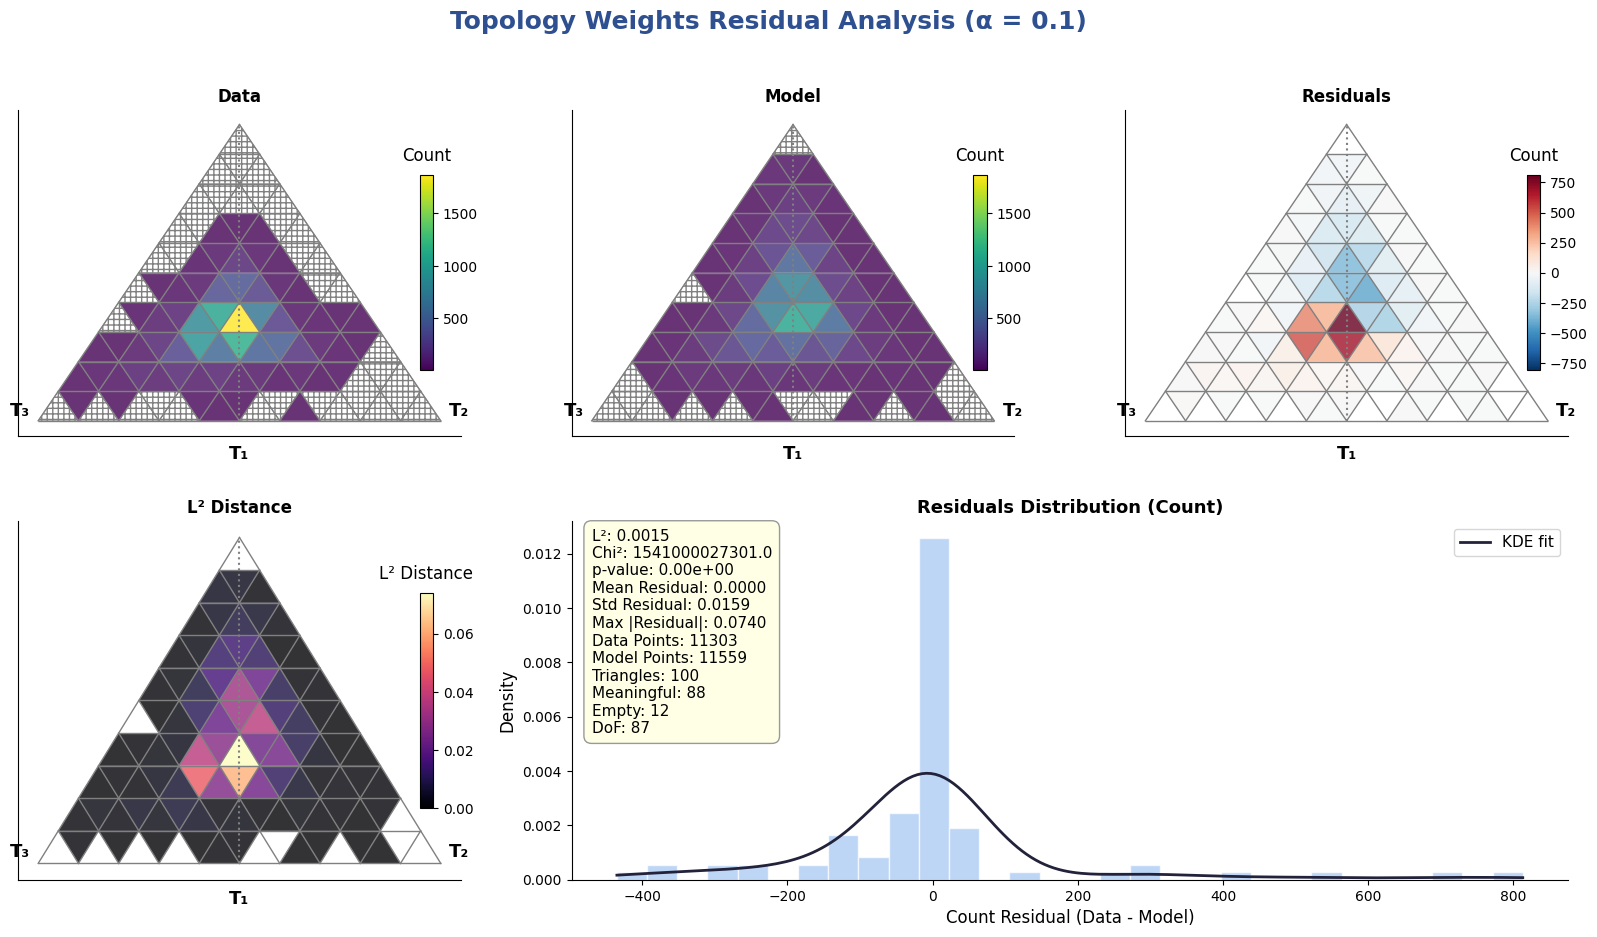


 2D Analysis complete!
 Results saved in: residual_results/
 Figure: analysis_analysis_granularity_0.1.png
 Data: analysis_results_granularity_0.1.csv
 Stats: analysis_statistics_granularity_0.1.txt


In [62]:
# RUN 2D RESIDUAL ANALYSIS
# ============================================================================

# Run the comprehensive analysis
fig_2d, results_df, statistics = run_comprehensive_analysis(
    data1=data1, 
    data2=data2, 
    alpha=GRANULARITY,
    output_dir=OUTPUT_DIR,
    compute_wasserstein=not SKIP_WASSERSTEIN
)

# Display the figure
plt.show()

print("\n 2D Analysis complete!")
print(f" Results saved in: {OUTPUT_DIR}/")
print(f" Figure: {OUTPUT_PREFIX}_analysis_granularity_{GRANULARITY}.png")
print(f" Data: {OUTPUT_PREFIX}_results_granularity_{GRANULARITY}.csv")
print(f" Stats: {OUTPUT_PREFIX}_statistics_granularity_{GRANULARITY}.txt")


In [63]:
# 3D VISUALIZATION FUNCTIONS
# ============================================================================

class Interactive3DPlot:
    """Interactive 3D ternary plot with navigation controls."""
    
    def __init__(self, data, colormap=COLORMAP_3D, alpha=ALPHA_3D, figsize=FIGURE_SIZE_3D):
        self.data = data
        self.colormap = colormap
        self.alpha = alpha
        self.figsize = figsize
        self.fig = None
        self.ax = None
        self.current_view = 'default'
        
        # View presets
        self.view_presets = {
            'default': {'elev': 57, 'azim': -68},
            'top': {'elev': 90, 'azim': 0},
            'side1': {'elev': 0, 'azim': 0},
            'side2': {'elev': 0, 'azim': 90},
            'corner': {'elev': 30, 'azim': 45}
        }
        
        # Create the plot
        self.create_plot()
        self.setup_interactions()
        
    def create_plot(self):
        """Create the 3D plot with data."""
        print("🎨 Creating 3D histogram...")
        
        # Calculate histogram data
        triangles = create_triangular_grid_twiss(self.alpha)
        counts = []
        
        for triangle in triangles:
            (a1, b1), (a2, b2), (a3, b3) = triangle['T1'], triangle['T2'], triangle['T3']
            count = n_twisstcompare(a1, b1, a2, b2, a3, b3, self.data)
            counts.append(count)
        
        counts = np.array(counts)
        print(f"📊 Processed {len(triangles)} triangular bins")
        print(f"📈 Count range: {counts.min()} to {counts.max()}")
        
        # Create figure
        self.fig = plt.figure(figsize=self.figsize)
        self.ax = self.fig.add_subplot(111, projection='3d')
        
        # Style the plot
        self.ax.grid(False)
        self.ax.set_axis_off()
        for axis in [self.ax.xaxis, self.ax.yaxis, self.ax.zaxis]:
            axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            axis.line.set_color((1.0, 1.0, 1.0, 0.0))
        
        # Add labels
        self.ax.text(0, h, 0, "T₁", color="black", fontsize=18, weight="bold", ha="center", va="bottom")
        self.ax.text(-0.5, 0, 0, "T₂", color="black", fontsize=18, weight="bold", ha="right", va="top")
        self.ax.text(0.5, 0, 0, "T₃", color="black", fontsize=18, weight="bold", ha="left", va="top")
        
        # Setup colormap
        cmap = get_professional_colormap(self.colormap, truncate=False)
        norm = Normalize(vmin=counts[counts>0].min() if np.any(counts>0) else 0, vmax=counts.max())
        
        # Draw 3D bars
        for idx, triangle in enumerate(triangles):
            if counts[idx] == 0:
                continue
                
            (a1, b1), (a2, b2), (a3, b3) = triangle['T1'], triangle['T2'], triangle['T3']
            trianglex, triangley, _ = return_triangle_coord(a1, b1, a2, b2, a3, b3)
            z0 = 0
            z1 = counts[idx]
            
            # Create 3D prism
            vertices = []
            # Base triangle
            base = [(trianglex[i], triangley[i], z0) for i in range(3)]
            # Top triangle
            top = [(trianglex[i], triangley[i], z1) for i in range(3)]
            
            # Create faces
            faces = []
            # Base and top
            faces.append(base)
            faces.append(top)
            # Sides
            for i in range(3):
                face = [base[i], base[(i+1)%3], top[(i+1)%3], top[i]]
                faces.append(face)
            
            # Color based on height
            color = cmap(norm(z1))
            
            # Add to plot
            poly3d = Poly3DCollection(faces, alpha=0.8, facecolor=color, edgecolor='black', linewidth=0.1)
            self.ax.add_collection3d(poly3d)
        
        # Set initial view
        self.set_view('default')
        
        # Add title with instructions
        self.fig.suptitle('Interactive 3D Ternary Plot\\nMouse: Rotate/Zoom | Keys: r(reset), s(save), 1-4(views), h(help)', 
                         fontsize=12, y=0.95)
        
        print("✅ 3D plot created successfully!")
    
    def set_view(self, view_name):
        """Set predefined view angle."""
        if view_name in self.view_presets:
            view = self.view_presets[view_name]
            self.ax.view_init(elev=view['elev'], azim=view['azim'])
            self.current_view = view_name
            print(f"📐 View set to: {view_name} (elev={view['elev']}, azim={view['azim']})")
            if self.fig.canvas:
                self.fig.canvas.draw()
    
    def save_figure(self, filename=None):
        """Save current figure."""
        if filename is None:
            filename = f"interactive_3D_{self.current_view}.png"
        self.fig.savefig(filename, dpi=SAVE_HIGH_DPI, bbox_inches='tight')
        print(f"💾 Figure saved as: {filename}")
    
    def print_help(self):
        """Print help information."""
        help_text = f"""
🎮 INTERACTIVE 3D NAVIGATION CONTROLS:

Mouse Controls:
  • Left click + drag: Rotate the 3D view
  • Right click + drag: Pan the view  
  • Scroll wheel: Zoom in/out

Keyboard Shortcuts:
  • 'r': Reset to default view (elev=57, azim=-68)
  • 's': Save current figure
  • '1': Top view (looking down)
  • '2': Side view 1 
  • '3': Side view 2
  • '4': Corner view
  • 'h': Print this help

Current view: {self.current_view}
Current angles: elev={self.ax.elev:.1f}, azim={self.ax.azim:.1f}
        """
        print(help_text.strip())
    
    def on_key_press(self, event):
        """Handle keyboard events."""
        if event.key == 'r':
            self.set_view('default')
        elif event.key == 's':
            self.save_figure()
        elif event.key == '1':
            self.set_view('top')
        elif event.key == '2':
            self.set_view('side1')
        elif event.key == '3':
            self.set_view('side2')
        elif event.key == '4':
            self.set_view('corner')
        elif event.key == 'h':
            self.print_help()
    
    def setup_interactions(self):
        """Setup interactive controls."""
        # Connect keyboard events
        self.fig.canvas.mpl_connect('key_press_event', self.on_key_press)
        
        # Print initial help
        print("\n" + "="*60)
        print("🎮 INTERACTIVE 3D TERNARY PLOT READY!")
        print("="*60)
        self.print_help()
        print("="*60)
    
    def show(self):
        """Display the interactive plot."""
        return self.fig


def create_3d_visualization(data, title="3D Ternary Histogram"):
    """Create an interactive 3D visualization of ternary data."""
    print(f"🚀 Creating 3D visualization: {title}")
    plot3d = Interactive3DPlot(data, colormap=COLORMAP_3D, alpha=ALPHA_3D, figsize=FIGURE_SIZE_3D)
    return plot3d

print("3D visualization functions defined!")


3D visualization functions defined!


## 2.  3D Visualization

**THIS SADLY DOESNT WORK: Controls:**
- **Mouse**: Left-click and drag to rotate, scroll to zoom, right-click and drag to pan
- **Keyboard**: Press 'h' in the plot window for help, 'r' to reset view, 's' to save, '1'-'4' for preset views


 Creating 3D visualization for Dataset 1: migration_topology_weights
🚀 Creating 3D visualization: 3D Histogram - migration_topology_weights
🎨 Creating 3D histogram...
📊 Processed 10000 triangular bins
📈 Count range: 0 to 38
📐 View set to: default (elev=57, azim=-68)
✅ 3D plot created successfully!

🎮 INTERACTIVE 3D TERNARY PLOT READY!
🎮 INTERACTIVE 3D NAVIGATION CONTROLS:

Mouse Controls:
  • Left click + drag: Rotate the 3D view
  • Right click + drag: Pan the view  
  • Scroll wheel: Zoom in/out

Keyboard Shortcuts:
  • 'r': Reset to default view (elev=57, azim=-68)
  • 's': Save current figure
  • '1': Top view (looking down)
  • '2': Side view 1 
  • '3': Side view 2
  • '4': Corner view
  • 'h': Print this help

Current view: default
Current angles: elev=57.0, azim=-68.0


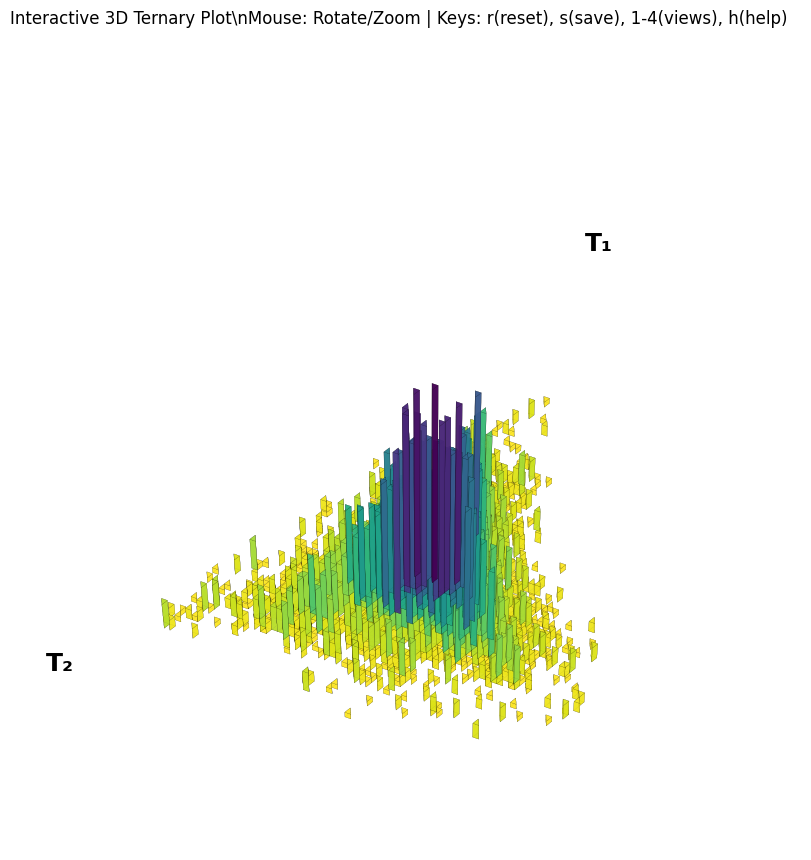

In [64]:
# ============================================================================
# (was supposed to be interactive) 3D PLOT - 
# ============================================================================
data_name = data1_name
data=data1
print(f" Creating 3D visualization for Dataset 1: {data_name}")

# Create 3D plot for data
plot3d = create_3d_visualization(data, title=f"3D Histogram - {data_name}")
fig_3d = plot3d.show()

# print(f"✅ 3D plot ready! Click on the plot window and use mouse/keyboard controls.")
# print(" Try pressing 'h' in the plot window for help with controls!")


 ## 3. COMPARIOSN PLOTS

 ### **The experiments from Sean**

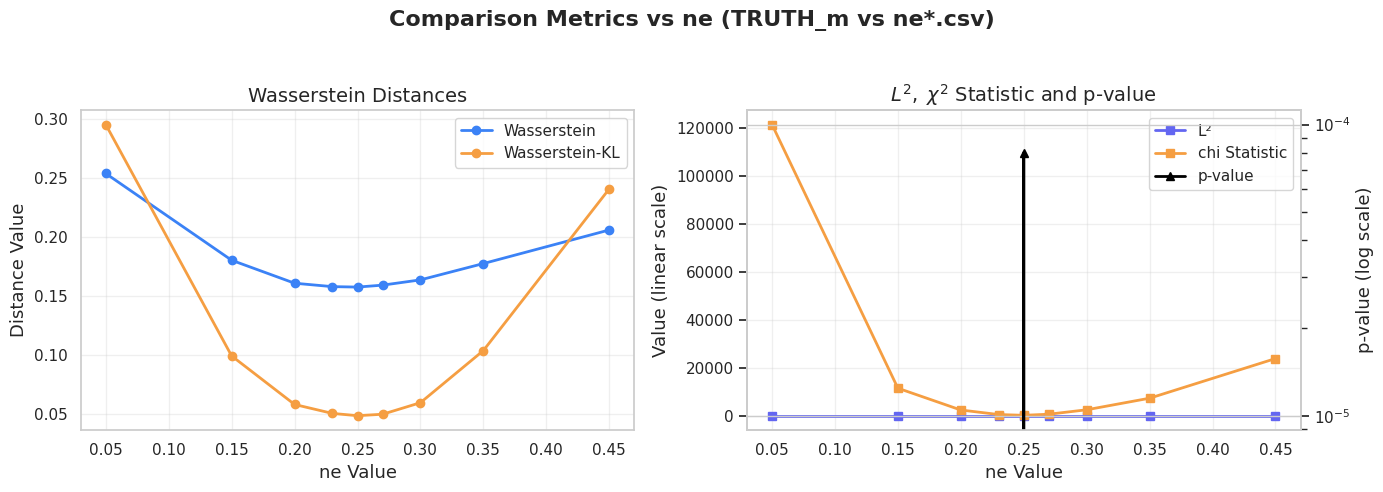

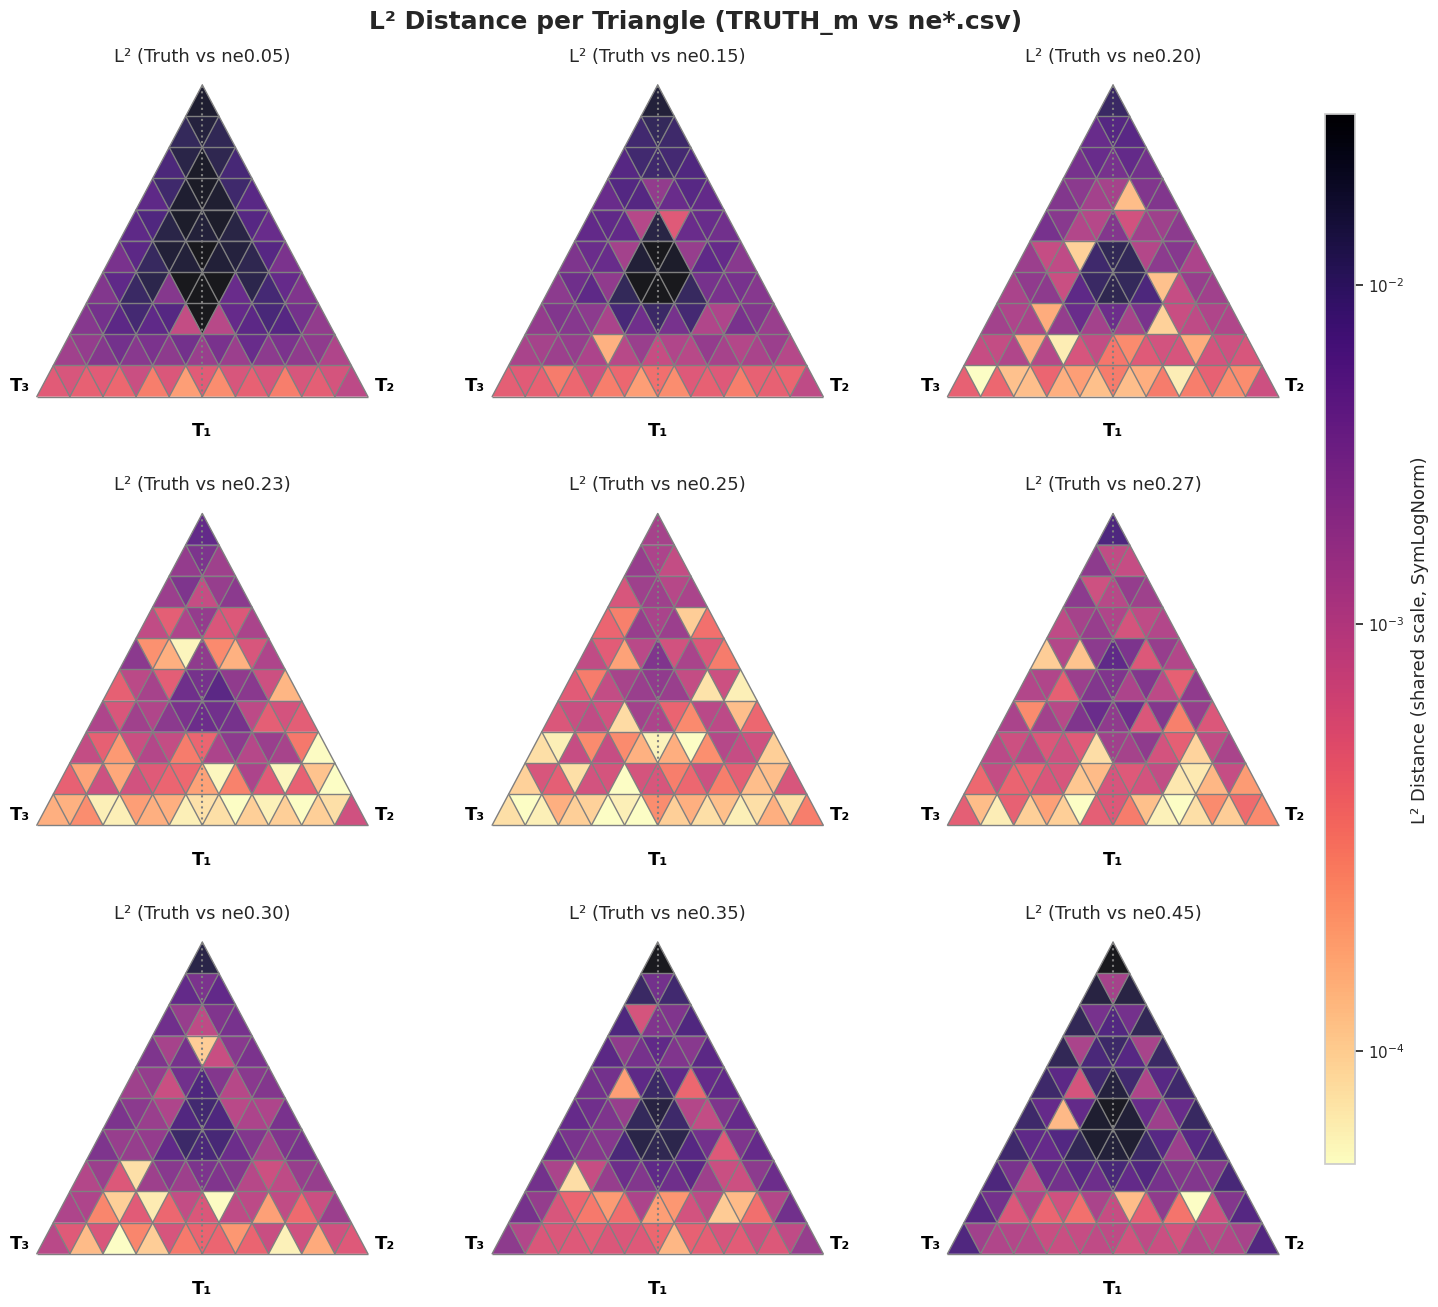

In [65]:
# --- PROFESSIONAL COMPARISON ANALYSIS: TRUTH vs NE FILES ---


sns.set_context('notebook')
sns.set_style('whitegrid')

alpha = 0.1
truth_file = "csv files/samples_14.6_testing_NN/TRUTH_ne0.25_1.csv"
ne_directory = "csv files/samples_14.6_testing_NN/"

# --- Suppress all output during metric and triangle calculations ---
class suppress_output:
    def __enter__(self):
        self._stdout = contextlib.redirect_stdout(io.StringIO())
        self._stderr = contextlib.redirect_stderr(io.StringIO())
        self._stdout.__enter__()
        self._stderr.__enter__()
    def __exit__(self, exc_type, exc_val, exc_tb):
        self._stdout.__exit__(exc_type, exc_val, exc_tb)
        self._stderr.__exit__(exc_type, exc_val, exc_tb)

# --- Load truth data ---
with suppress_output():
    data1 = load_topology_data_twiss(truth_file)

# --- Find all ne*.csv files ---
ne_files = [f for f in os.listdir(ne_directory) if f.startswith("ne") and f.endswith(".csv")]
ne_files.sort()

# --- Initialize results storage ---
results = []
ternary_l2_arrays = []
ternary_results_dfs = []
ne_values = []

for ne_file in ne_files:
    ne_match = re.search(r'ne(\d+\.\d+)', ne_file)
    if ne_match:
        ne_value = float(ne_match.group(1))
    else:
        continue
    ne_file_path = os.path.join(ne_directory, ne_file)
    with suppress_output():
        data2 = load_topology_data_twiss(ne_file_path)
        metrics = compute_all_metrics(data1, data2, alpha=alpha)
        # For ternary L2 plot, get the results_df from perform_enhanced_grid_analysis
        results_df, _ = perform_enhanced_grid_analysis(data1, data2, alpha)
    # Store metrics
    results.append({
        'ne_value': ne_value,
        'filename': ne_file,
        'L_2': metrics['L2_distance'],
        'chi2': metrics['chi2_statistic'],
        'p_value': metrics['p_value'],
        'wasserstein': metrics['wasserstein_euclidean'],
        'wasserstein_kl': metrics['wasserstein_kl'],
    })
    # Store triangle L2 array for robust colorbar
    l2_per_triangle = np.sqrt(results_df['residual_squared'].values)
    ternary_l2_arrays.append(l2_per_triangle)
    ternary_results_dfs.append(results_df)
    ne_values.append(ne_value)

# --- Compute robust colorbar limits (1st/99th percentiles) ---
all_l2 = np.concatenate(ternary_l2_arrays)
vmin = np.nanpercentile(all_l2, 1)
vmax = np.nanpercentile(all_l2, 99)
# Use SymLogNorm for perceptual sensitivity (linear near zero, log elsewhere)
linthresh = max(1e-5, (vmax-vmin)/100)
norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap(L2_COLORMAP_COMPARE)

# --- Convert results to DataFrame and sort by ne_value ---
results_df = pd.DataFrame(results).sort_values('ne_value')
ne_values_sorted = results_df['ne_value'].values

# --- Plot Wasserstein & Wasserstein-KL ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax1, ax2 = axes
fig.suptitle('Comparison Metrics vs ne (TRUTH_m vs ne*.csv)', fontsize=16, fontweight='bold')

# --- Plot 1: Wasserstein distances ---
ax1.plot(results_df['ne_value'], results_df['wasserstein'], 'o-', label='Wasserstein', color='#3B82F6', linewidth=2)
ax1.plot(results_df['ne_value'], results_df['wasserstein_kl'], 'o-', label='Wasserstein-KL', color='#F59E42', linewidth=2)
ax1.set_xlabel('ne Value', fontsize=13)
ax1.set_ylabel('Distance Value', fontsize=13)
ax1.set_title('Wasserstein Distances', fontsize=14)
ax1.legend(frameon=True)
ax1.grid(True, alpha=0.3)

# --- Plot 2: L2, Chi2, and p-value (secondary y-axis) ---
ax2.plot(results_df['ne_value'], results_df['L_2'], 's-', label='L²', color='#6366F1', linewidth=2)
ax2.plot(results_df['ne_value'], results_df['chi2'], 's-', label='chi Statistic', color='#F59E42', linewidth=2)
ax2.set_xlabel('ne Value', fontsize=13)
ax2.set_ylabel('Value (linear scale)', fontsize=13)
ax2.set_title(r'$L^2$, $\,\chi^2$ Statistic and p-value', fontsize=14)
ax2.grid(True, alpha=0.3)

ax2b = ax2.twinx()
ax2b.plot(results_df['ne_value'], results_df['p_value'], '^-k', label='p-value', linewidth=2)
ax2b.set_yscale('log')
ax2b.set_ylabel('p-value (log scale)', fontsize=13)

# --- Legends ---
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Grid of ternary L2 plots ---
import math
n_plots = len(ne_values)
ncols = 3
nrows = math.ceil(n_plots / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
fig.suptitle('L² Distance per Triangle (TRUTH_m vs ne*.csv)', fontsize=18, fontweight='bold', y=0.92)

for idx, (results_df_tri, ne_val) in enumerate(zip(ternary_results_dfs, ne_values)):
    row, col = divmod(idx, ncols)
    ax = axes[row, col] if nrows > 1 else axes[col]
    # --- Plot using the notebook's function, but override color normalization ---
    plot_ternary_base_twiss(ax, alpha)
    l2_per_triangle = np.sqrt(results_df_tri['residual_squared'].values)
    for i, row_df in results_df_tri.iterrows():
        has_data = (row_df['count_data'] > 0) or (row_df['count_model'] > 0)
        trianglex, triangley, _ = return_triangle_coord(
            row_df['T1_bounds'][0], row_df['T1_bounds'][1],
            row_df['T2_bounds'][0], row_df['T2_bounds'][1],
            row_df['T3_bounds'][0], row_df['T3_bounds'][1]
        )
        if not has_data:
            draw_empty_triangle(ax, trianglex, triangley, hatch=False)
        else:
            color = cmap(norm(l2_per_triangle[i]))
            ax.fill(trianglex, triangley, color=color, edgecolor='none', alpha=0.9)
    ax.set_title(f"L² (Truth vs ne{ne_val:.2f})", fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# Remove empty subplots
for idx in range(n_plots, nrows*ncols):
    row, col = divmod(idx, ncols)
    fig.delaxes(axes[row, col] if nrows > 1 else axes[col])

# --- Add a single colorbar for all ternary plots ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('L² Distance (shared scale, SymLogNorm)', fontsize=13)

plt.subplots_adjust(left=0.05, right=0.9, top=0.88, bottom=0.08, wspace=0.25, hspace=0.25)
plt.show()


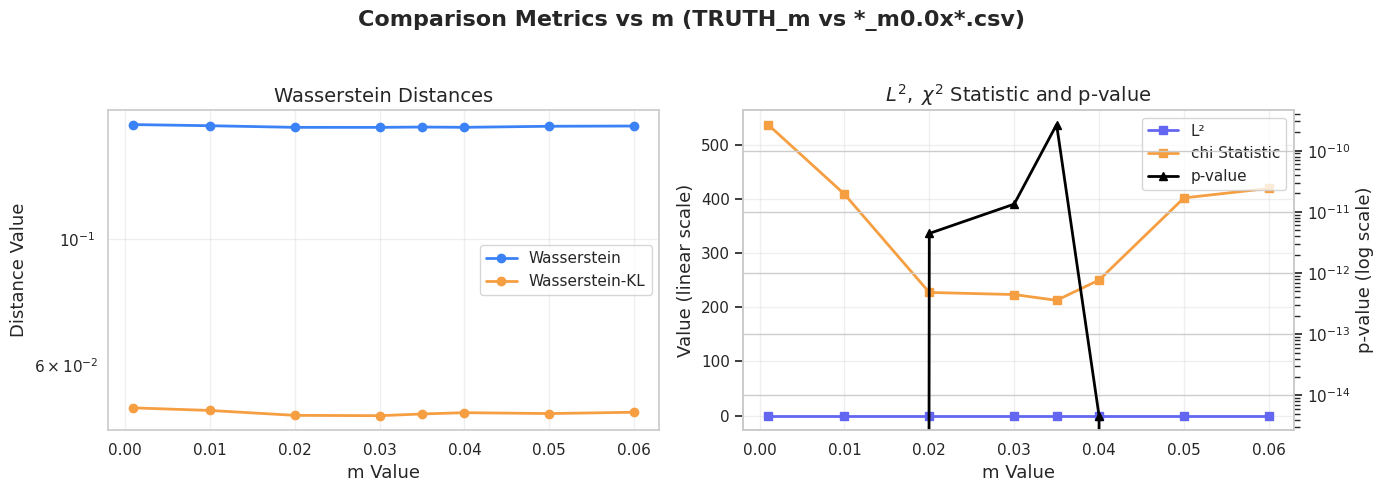

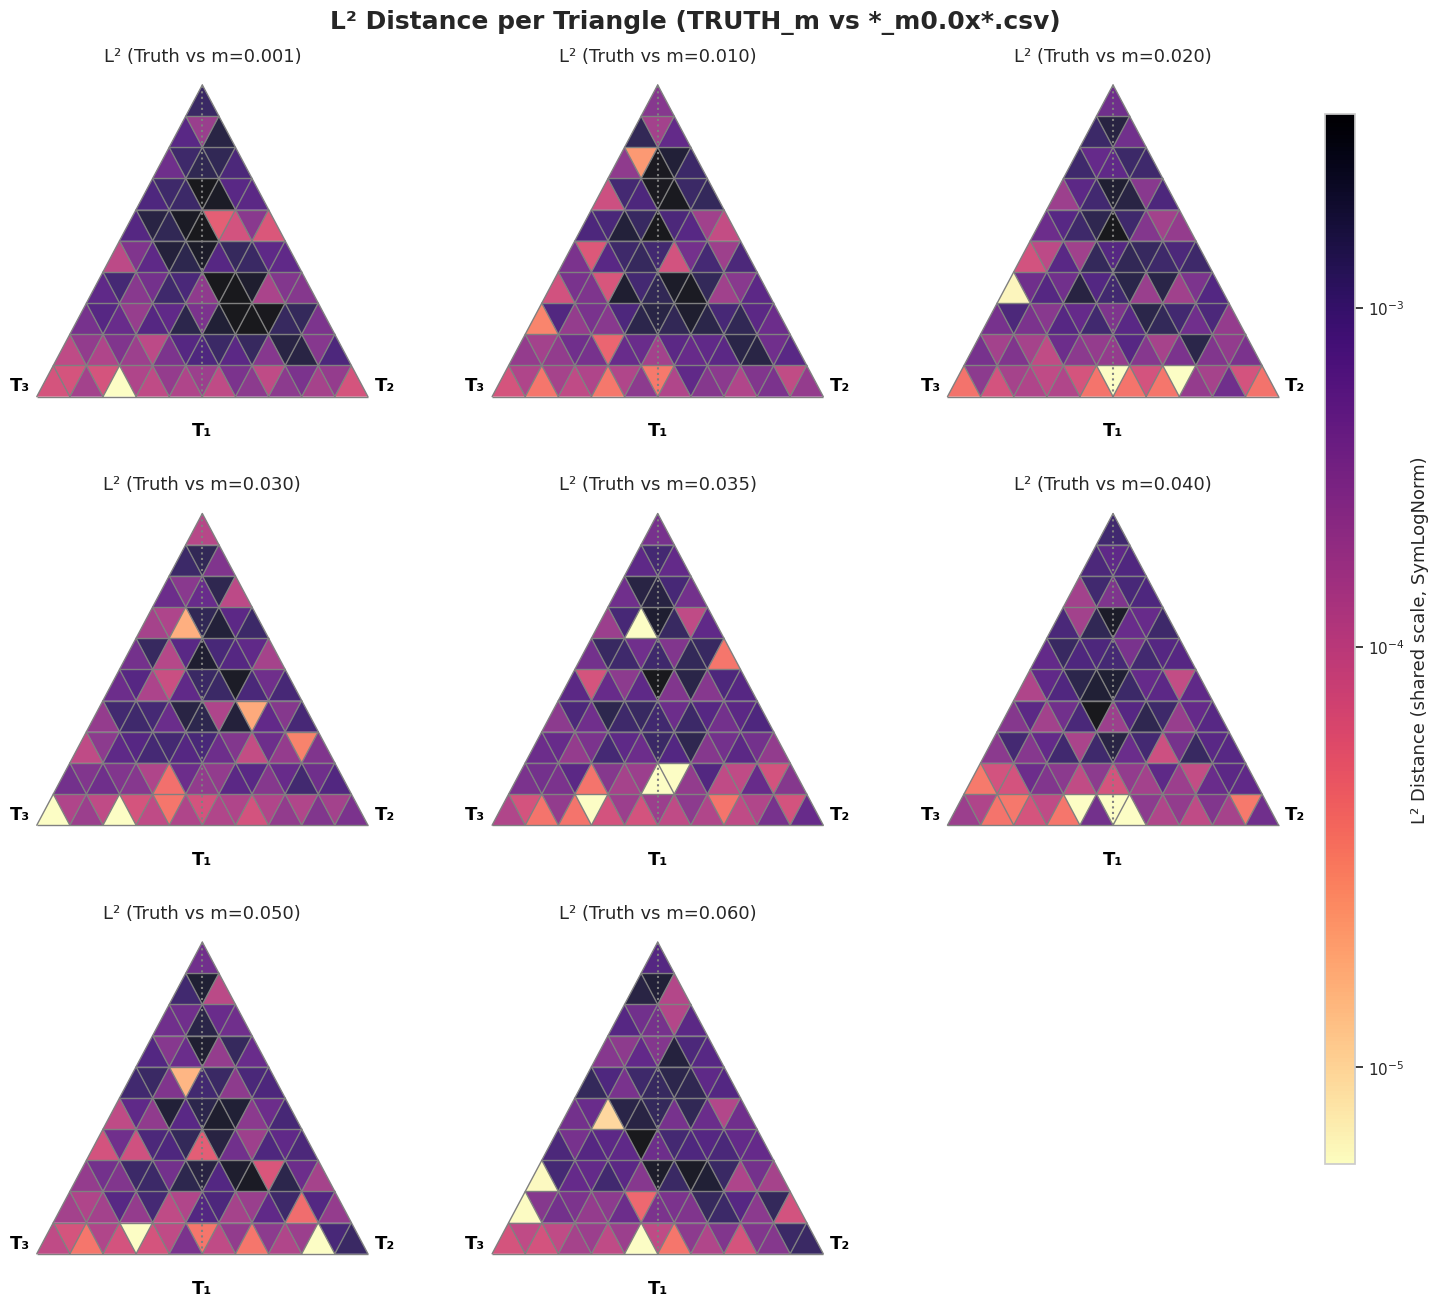

In [66]:
# --- PROFESSIONAL COMPARISON ANALYSIS: TRUTH vs *_m0.0x FILES ---


sns.set_context('notebook')
sns.set_style('whitegrid')

alpha = 0.1
truth_file = "csv files/samples_14.6_testing_NN/TRUTH_m.csv"
m_directory = "csv files/samples_14.6_testing_NN/"

# --- Suppress all output during metric and triangle calculations ---
class suppress_output:
    def __enter__(self):
        self._stdout = contextlib.redirect_stdout(io.StringIO())
        self._stderr = contextlib.redirect_stderr(io.StringIO())
        self._stdout.__enter__()
        self._stderr.__enter__()
    def __exit__(self, exc_type, exc_val, exc_tb):
        self._stdout.__exit__(exc_type, exc_val, exc_tb)
        self._stderr.__exit__(exc_type, exc_val, exc_tb)

# --- Load truth data ---
with suppress_output():
    data1 = load_topology_data_twiss(truth_file)

# --- Find all *_m0.0x*.csv files ---
m_files = [f for f in os.listdir(m_directory) if re.search(r'_m0\.\d+', f) and f.endswith('.csv')]
m_files.sort()

# --- Initialize results storage ---
results = []
ternary_l2_arrays = []
ternary_results_dfs = []
m_values = []

for m_file in m_files:
    m_match = re.search(r'_m0\.(\d+)', m_file)
    if m_match:
        m_value = float('0.' + m_match.group(1))
    else:
        continue
    m_file_path = os.path.join(m_directory, m_file)
    with suppress_output():
        data2 = load_topology_data_twiss(m_file_path)
        metrics = compute_all_metrics(data1, data2, alpha=alpha)
        results_df, _ = perform_enhanced_grid_analysis(data1, data2, alpha)
    results.append({
        'm_value': m_value,
        'filename': m_file,
        'L_2': metrics['L2_distance'],
        'chi2': metrics['chi2_statistic'],
        'p_value': metrics['p_value'],
        'wasserstein': metrics['wasserstein_euclidean'],
        'wasserstein_kl': metrics['wasserstein_kl'],
    })
    l2_per_triangle = np.sqrt(results_df['residual_squared'].values)
    ternary_l2_arrays.append(l2_per_triangle)
    ternary_results_dfs.append(results_df)
    m_values.append(m_value)

# --- Compute robust colorbar limits (1st/99th percentiles) ---
all_l2 = np.concatenate(ternary_l2_arrays)
vmin = np.nanpercentile(all_l2, 1)
vmax = np.nanpercentile(all_l2, 99)
linthresh = max(1e-5, (vmax-vmin)/100)
norm = SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax)
cmap = plt.get_cmap(L2_COLORMAP_COMPARE)

# --- Convert results to DataFrame and sort by m_value ---
results_df = pd.DataFrame(results).sort_values('m_value')
m_values_sorted = results_df['m_value'].values

# --- Plot Wasserstein & Wasserstein-KL ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax1, ax2 = axes
fig.suptitle('Comparison Metrics vs m (TRUTH_m vs *_m0.0x*.csv)', fontsize=16, fontweight='bold')

# --- Plot 1: Wasserstein distances ---
ax1.plot(results_df['m_value'], results_df['wasserstein'], 'o-', label='Wasserstein', color='#3B82F6', linewidth=2)
ax1.plot(results_df['m_value'], results_df['wasserstein_kl'], 'o-', label='Wasserstein-KL', color='#F59E42', linewidth=2)
ax1.set_xlabel('m Value', fontsize=13)
ax1.set_yscale('log')
ax1.set_ylabel('Distance Value', fontsize=13)
ax1.set_title('Wasserstein Distances', fontsize=14)
ax1.legend(frameon=True)
ax1.grid(True, alpha=0.3)

# --- Plot 2: L2, Chi2, and p-value (secondary y-axis) ---
ax2.plot(results_df['m_value'], results_df['L_2'], 's-', label='L²', color='#6366F1', linewidth=2)
ax2.plot(results_df['m_value'], results_df['chi2'], 's-', label='chi Statistic', color='#F59E42', linewidth=2)
ax2.set_xlabel('m Value', fontsize=13)
ax2.set_ylabel('Value (linear scale)', fontsize=13)
ax2.set_title(r'$L^2$, $\,\chi^2$ Statistic and p-value', fontsize=14)
ax2.grid(True, alpha=0.3)

ax2b = ax2.twinx()
ax2b.plot(results_df['m_value'], results_df['p_value'], '^-k', label='p-value', linewidth=2)
ax2b.set_yscale('log')
ax2b.set_ylabel('p-value (log scale)', fontsize=13)

lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2b.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Grid of ternary L2 plots ---
import math
n_plots = len(m_values)
ncols = 3
nrows = math.ceil(n_plots / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
fig.suptitle('L² Distance per Triangle (TRUTH_m vs *_m0.0x*.csv)', fontsize=18, fontweight='bold', y=0.92)

for idx, (results_df_tri, m_val) in enumerate(zip(ternary_results_dfs, m_values)):
    row, col = divmod(idx, ncols)
    ax = axes[row, col] if nrows > 1 else axes[col]
    plot_ternary_base_twiss(ax, alpha)
    l2_per_triangle = np.sqrt(results_df_tri['residual_squared'].values)
    for i, row_df in results_df_tri.iterrows():
        has_data = (row_df['count_data'] > 0) or (row_df['count_model'] > 0)
        trianglex, triangley, _ = return_triangle_coord(
            row_df['T1_bounds'][0], row_df['T1_bounds'][1],
            row_df['T2_bounds'][0], row_df['T2_bounds'][1],
            row_df['T3_bounds'][0], row_df['T3_bounds'][1]
        )
        if not has_data:
            draw_empty_triangle(ax, trianglex, triangley, hatch=False)
        else:
            color = cmap(norm(l2_per_triangle[i]))
            ax.fill(trianglex, triangley, color=color, edgecolor='none', alpha=0.9)
    ax.set_title(f"L² (Truth vs m={m_val:.3f})", fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

for idx in range(n_plots, nrows*ncols):
    row, col = divmod(idx, ncols)
    fig.delaxes(axes[row, col] if nrows > 1 else axes[col])

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('L² Distance (shared scale, SymLogNorm)', fontsize=13)

plt.subplots_adjust(left=0.05, right=0.9, top=0.88, bottom=0.08, wspace=0.25, hspace=0.25)
plt.show()


## 4. PLOTTING REAL DATA